In [43]:
from Bio import SeqIO
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

PATH_TO_SEQS = 'test_data.fasta'
SEPARATE_GENES = False #for gb
PATH_TO_RESULT = '../../figures'

#TODO: ~~add fasta parser~~ 
# ~~add strand check for gb~~
# ~~add global parsing (not separating by genes)~~
# ~~fix graphs~~
# ~~add multiple files processing~~
# add saving tables and plots


In [44]:

skew_types = ['AT', 'AG', 'AC', 'TA', 'TG','TC', 'GT', 'GA', 'GC', 'CG', 'CA', 'CT']
    
def gb_parser(PATH_TO_GB, GENE_CONDITION):
    # check for multi file input
    if len(PATH_TO_GB.split(',')) > 1:
        with open('single.gb', 'w') as fout:
            for file in PATH_TO_SEQS.split(','):
                with open(file.strip()) as fin:  
                    for line in fin:
                        fout.write(line)
        entries = list(SeqIO.parse('single.gb', 'genbank'))
        os.remove('single.gb')
    else:
        entries = list(SeqIO.parse(PATH_TO_GB, 'genbank'))
    characteristics_list = ['Species', 'Taxonomy', 'Sequence', 'A', 'T','G', 'C']
    characteristics = {}
    for char in characteristics_list:
        characteristics[char] = 0
    df = pd.DataFrame(columns=characteristics_list)
    for entry in entries:
        characteristics['Species'] = entry.annotations['organism']
        characteristics['Taxonomy'] = entry.annotations['taxonomy']
        if GENE_CONDITION == True:
            #checking for genes
            for feat in entry.features:
                if feat.type == 'CDS':
                    if 'gene' not in feat.qualifiers:
                        characteristics['Gene_name'] = 'NA'
                    else:
                        characteristics['Gene_name'] = ''.join(feat.qualifiers['gene'])
                    #checking strands
                    if feat.strand == 1:
                        characteristics['Sequence'] = feat.location.extract(entry).seq
                    else:
                        characteristics['Sequence'] = feat.location.extract(entry).seq.reverse_complement()
                    characteristics['A'] = characteristics['Sequence'].count('A')
                    characteristics['T'] = characteristics['Sequence'].count('T')
                    characteristics['G'] = characteristics['Sequence'].count('G')
                    characteristics['C'] = characteristics['Sequence'].count('C')
                    df = df.append(characteristics, ignore_index=True)
        else:
            characteristics['Sequence'] = entry.seq
            characteristics['A'] = characteristics['Sequence'].count('A')
            characteristics['T'] = characteristics['Sequence'].count('T')
            characteristics['G'] = characteristics['Sequence'].count('G')
            characteristics['C'] = characteristics['Sequence'].count('C')
            df = df.append(characteristics, ignore_index=True)
            
    for skew_type in skew_types:
        dividend = list(skew_type)[0]
        divisor = list(skew_type)[1]
        skew = (df[dividend] - df[divisor])/(df[dividend] + df[divisor])
        df = df.merge(skew.rename(f'{skew_type}skew'), left_index=True, right_index=True)
    return df

def fasta_parser(PATH_TO_FASTA):
    # check for multi file input
    if len(PATH_TO_FASTA.split(',')) > 1:
        with open('single.fasta', 'w') as fout:
            for file in PATH_TO_SEQS.split(','):
                with open(file.strip()) as fin:  
                    for line in fin:
                        fout.write(line)
        entries = list(SeqIO.parse('single.fasta', 'fasta'))
        os.remove('single.fasta')
    else:
        entries = list(SeqIO.parse(PATH_TO_FASTA, 'fasta'))
    characteristics_list = ['Species ID', 'Sequence', 'A', 'T','G', 'C']
    characteristics = {}
    for char in characteristics_list:
        characteristics[char] = 0
    df = pd.DataFrame(columns=characteristics_list)
    for entry in entries:
        characteristics['Species ID'] = entry.id
        characteristics['Sequence'] = entry.seq
        characteristics['A'] = characteristics['Sequence'].count('A')
        characteristics['T'] = characteristics['Sequence'].count('T')
        characteristics['G'] = characteristics['Sequence'].count('G')
        characteristics['C'] = characteristics['Sequence'].count('C')
        df = df.append(characteristics, ignore_index=True)
    for skew_type in skew_types:
        dividend = list(skew_type)[0]
        divisor = list(skew_type)[1]
        skew = (df[dividend] - df[divisor])/(df[dividend] + df[divisor])
        df = df.merge(skew.rename(f'{skew_type}skew'), left_index=True, right_index=True)
    return df

In [45]:

def plot_nucl_content(df):
    if 'Gene_name' in df.columns:
        fig, axes = plt.subplots(3, 4, sharey=True, figsize=(20,20))
        for row in range(3):
            for column in range(4):
                axes[row,column].set_xticklabels(axes[row,column].get_xticks(), rotation = 45) 
        sns.boxplot(data=df, ax=axes[0,0], x="Gene_name", y="ATskew")
        sns.boxplot(data=df, ax=axes[0,1], x="Gene_name", y="AGskew")
        sns.boxplot(data=df, ax=axes[0,2], x="Gene_name", y="ACskew")
        sns.boxplot(data=df, ax=axes[0,3], x="Gene_name", y="TAskew")
        sns.boxplot(data=df, ax=axes[1,0], x="Gene_name", y="TGskew")
        sns.boxplot(data=df, ax=axes[1,1], x="Gene_name", y="TCskew")
        sns.boxplot(data=df, ax=axes[1,2], x="Gene_name", y="GTskew")
        sns.boxplot(data=df, ax=axes[1,3], x="Gene_name", y="GAskew")
        sns.boxplot(data=df, ax=axes[2,0], x="Gene_name", y="GCskew")
        sns.boxplot(data=df, ax=axes[2,1], x="Gene_name", y="CGskew")
        sns.boxplot(data=df, ax=axes[2,2], x="Gene_name", y="CAskew")
        sns.boxplot(data=df, ax=axes[2,3], x="Gene_name", y="CTskew");
    else:
        #removing A, T, G, C because I'm lazy and/or stupid
        cropped_df = df.drop('A', axis=1)
        cropped_df = cropped_df.drop('T', axis=1)
        cropped_df = cropped_df.drop('G', axis=1)
        cropped_df = cropped_df.drop('C', axis=1)
        sns.boxplot(data=cropped_df)
        ax = sns.boxplot(data=cropped_df)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45);


In [46]:
if ('fasta' in PATH_TO_SEQS or 'fa' in PATH_TO_SEQS) and ('gb' in PATH_TO_SEQS): #bonus RAM usage
    print('Wonderful, you dong! Stop using both file types!')
elif 'gb' in PATH_TO_SEQS:
    df = gb_parser(PATH_TO_SEQS, SEPARATE_GENES)
elif 'fasta' in PATH_TO_SEQS or 'fa' in PATH_TO_SEQS:
    df = fasta_parser(PATH_TO_SEQS)
else:
    print('Unsupported file type, you fucking donkey! Use either fasta or genbank!')

In [47]:
df

,Species ID,Sequence,A,T,G,C,ATskew,AGskew,ACskew,TAskew,TGskew,TCskew,GTskew,GAskew,GCskew,CGskew,CAskew,CTskew
0,NC_014274.1,"(A, A, T, G, G, A, G, T, G, C, C, T, G, A, A, ...",6287,4917,1632,2717,0.122278,0.587827,0.39649,-0.122278,0.501603,0.288184,-0.501603,-0.587827,-0.249483,0.249483,-0.39649,-0.288184
1,NC_018549.1,"(A, A, T, G, A, A, G, T, G, C, C, T, G, A, T, ...",6432,5780,1711,2547,0.05339,0.579762,0.432676,-0.05339,0.543185,0.388255,-0.543185,-0.579762,-0.196336,0.196336,-0.432676,-0.388255
2,NC_013238.1,"(G, A, A, T, T, T, A, T, A, A, T, T, T, A, T, ...",7113,6743,1289,2672,0.026703,0.693168,0.453858,-0.026703,0.679034,0.432395,-0.679034,-0.693168,-0.349154,0.349154,-0.453858,-0.432395
3,NC_006076.1,"(G, A, T, A, A, A, G, T, G, C, C, T, G, A, A, ...",6318,4951,1552,2175,0.121306,0.605591,0.487813,-0.121306,0.522682,0.389559,-0.522682,-0.605591,-0.167159,0.167159,-0.487813,-0.389559
4,NC_039940.1,"(A, A, T, A, A, A, G, T, G, C, C, T, G, A, A, ...",6610,5094,1571,2329,0.129528,0.615939,0.478913,-0.129528,0.528582,0.372491,-0.528582,-0.615939,-0.194359,0.194359,-0.478913,-0.372491
5,NC_034842.1,"(A, A, T, A, A, A, G, T, G, C, C, T, G, A, A, ...",6644,5131,1598,2338,0.128493,0.61223,0.479403,-0.128493,0.525041,0.373946,-0.525041,-0.61223,-0.188008,0.188008,-0.479403,-0.373946
6,NC_034841.1,"(A, A, T, A, A, A, G, T, G, C, C, T, G, A, A, ...",6573,5122,1582,2328,0.12407,0.612017,0.476913,-0.12407,0.528043,0.375034,-0.528043,-0.612017,-0.190793,0.190793,-0.476913,-0.375034
7,NC_030003.1,"(A, A, T, A, A, A, G, T, G, C, C, T, G, A, G, ...",6559,5019,1591,2432,0.133011,0.609571,0.459015,-0.133011,0.518608,0.347202,-0.518608,-0.609571,-0.209048,0.209048,-0.459015,-0.347202
8,NC_030001.1,"(A, G, T, A, A, A, G, T, G, C, C, T, G, A, A, ...",5823,5492,1807,2870,0.029253,0.526343,0.339699,-0.029253,0.504864,0.313561,-0.504864,-0.526343,-0.227282,0.227282,-0.339699,-0.313561
9,NC_029224.1,"(A, G, T, A, A, A, G, T, G, C, C, T, G, A, A, ...",6751,5867,1709,3013,0.070059,0.595981,0.382835,-0.070059,0.548838,0.321396,-0.548838,-0.595981,-0.276154,0.276154,-0.382835,-0.321396


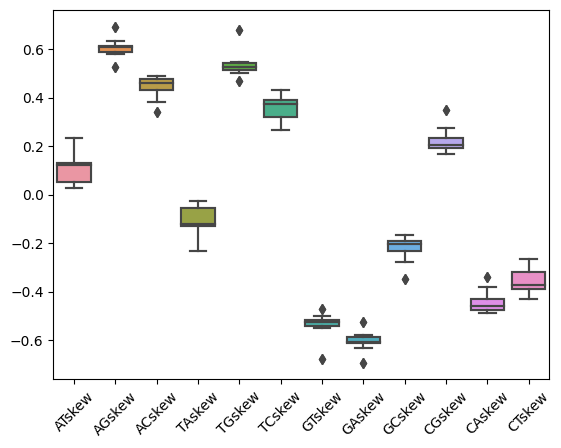

In [48]:
plot_nucl_content(df)